# Распознавание модели автомобилей на изображениях

## Данные

На данном этапе поддерживаются только 10 моделей автомобилей:
 - Honda Civic
 - Hyundai Accent
 - Hyundai Solaris
 - KIA Cee'd
 - KIA Rio
 - Lada Kalina
 - Mazda 3
 - Nissan Qashqai
 - Opel Astra
 - Toyota Camry
 
Из датасета были отобраны 'удачные' фотографии автомобилей. Далее они были обрезаны таким образом, чтобы убрать с фотографии все лишнее. Все полученные изображения имеют пропорции 4x5.

Вспомогательная функция, для отображения галлереи.

In [1]:
import matplotlib.pylab as plt
%matplotlib inline

def plot_gallery(gallery, n_row, n_col, row_labels):
    fig, axes = plt.subplots(nrows=n_row, ncols=n_col, figsize=(1.7 * n_col, 1.7 * n_row))
    
    for plot, img in zip(axes.ravel(), gallery):
        plot.imshow(img, interpolation='nearest')
        plot.set_xticks(())
        plot.set_yticks(())
    
    for ax, label in zip(axes[:, 0], row_labels):
        ax.annotate(label, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center')

    fig.subplots_adjust(left=.15, right=.9, bottom=0, top=0.9, wspace=0.2, hspace=0.35)
    fig.tight_layout()

Отобразим фотографии нескольких автомобилей из каждого класса.

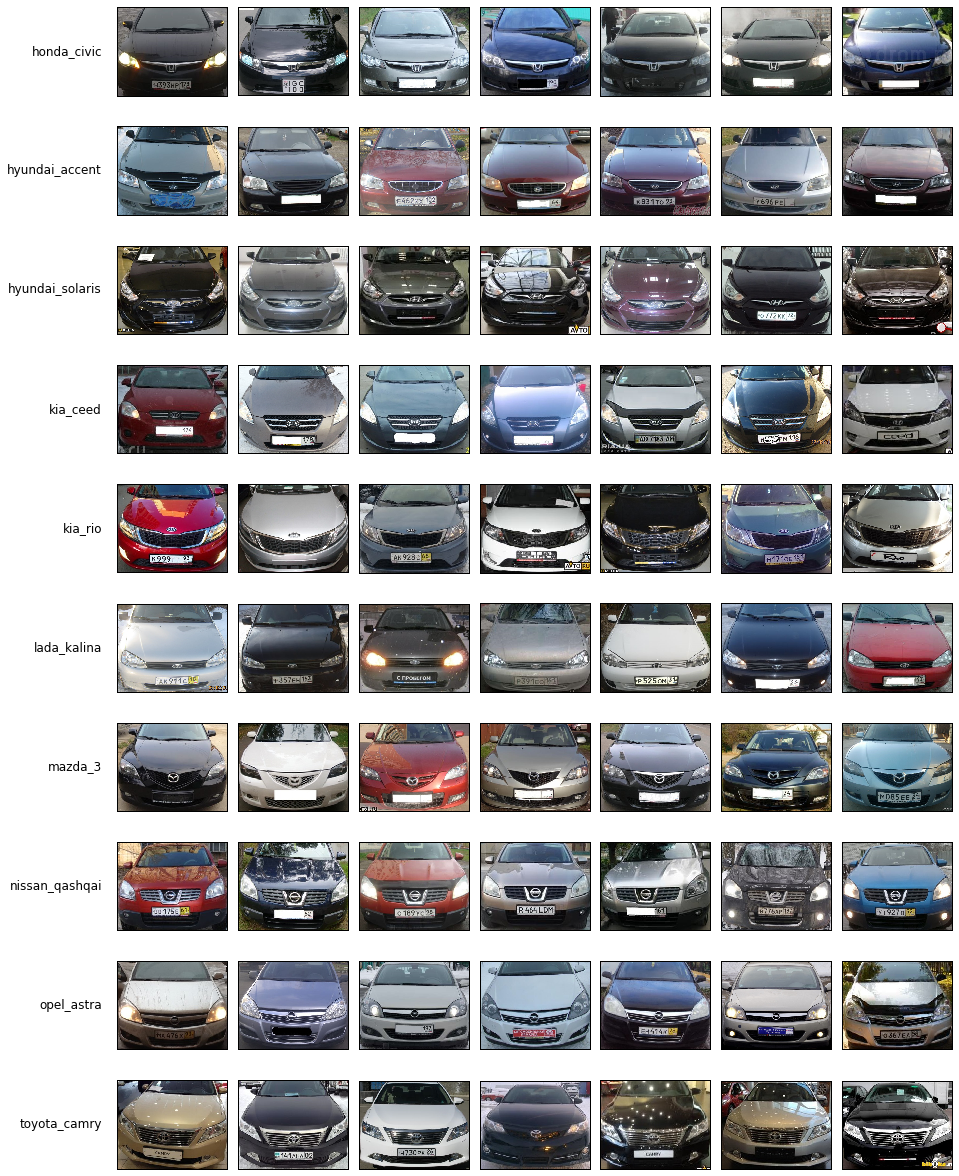

In [2]:
import glob
from itertools import islice
from skimage import io

models = ['honda_civic', 'hyundai_accent', 'hyundai_solaris', 'kia_ceed', 'kia_rio',
          'lada_kalina', 'mazda_3', 'nissan_qashqai', 'opel_astra', 'toyota_camry']

gallery = []
for model in models:
    img_paths = glob.iglob('datasets/alex/src/{}/*'.format(model))
    gallery.extend(io.imread(img_path) for img_path in islice(img_paths, 7))

plot_gallery(gallery, n_row=10, n_col=7, row_labels=models)

## Оценка качества модели

В качестве схемы кросс-валидации используется 5-fold cv, заданная с помощью класса [KFoldCV](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.KFold.html).

Для оценки качества предсказания классификатора используется наиболее очевидная метрика, а именно доля правильных ответов (accuracy):
$$accuracy = \frac{1}{n} \sum\limits_{i=1}^{n} [\alpha(x_i) = y_i]$$

In [3]:
from sklearn.cross_validation import cross_val_score, KFold, train_test_split

Функция для построения графика с результатами

In [4]:
import matplotlib.pylab as plt
import numpy as np

%matplotlib inline

def plot_quality(grid_scores, param, param_name):
    means = []
    stds = []
    for cv_validation_scores in grid_scores:
        means.append(np.mean(cv_validation_scores))
        stds.append(np.sqrt(np.var(cv_validation_scores)))
    means = np.array(means)
    stds = np.array(stds)

    plt.figure(figsize=(8, 6))
    plt.plot(param, means)
    plt.fill_between(param, means + stds, means - stds, alpha = 0.3, facecolor='blue')
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')

## Представление данных

Для описания фотографий автомобилей мы будем использовать дескриптор, известный под названием [Histogram of Oriented Gradient](http://scikit-image.org/docs/dev/auto_examples/plot_hog.html) (далее просто HOG). Это популярный дескриптор в задачах обнаружения объектов. При помощи него можно отлично описывать объекты, имеющие 'жесткую' модель, что как раз подходит для нашей задачи.

Дескриптор имеет несколко параметров. Нас будут интересовать два из них:
- pixels_per_cell - размер (в пикселях) каждой ячеейки
- cells_per_block - число ячеек в каждом блоке

По-умолчанию будем использовать размер ячейки 16x16 и размер блока 2x2, что обеспечит баланс между пространственной поддержкой дескриптора и размером его вектора.

In [5]:
from skimage.feature import hog

## Первая модель - Random Forest

В качестве первой модели будем использовать [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). Причиной тому является то, что данная модель способна показывать впечатляющие результаты даже без тонкой настройки её параметров. В качестве значения параметра, отвечающего за количество деревьев в лесе (*n_estimators*) выберем достаточно большое число - 300, т.к. данная модель не переобучается с увеличением количества деревьев.

In [6]:
from skimage import transform, io
from sklearn.ensemble import RandomForestClassifier

In [7]:
models = ['honda_civic', 'hyundai_accent', 'hyundai_solaris', 'kia_ceed',
          'kia_rio', 'lada_kalina', 'mazda_3', 'nissan_qashqai',
          'opel_astra', 'toyota_camry']

X, y = [], []

for i, model in enumerate(models):
    for img_name in glob.iglob('datasets/alex/src/{}/*'.format(model)):
        img = io.imread(fname=img_name, as_grey=True)
        img = transform.resize(image=img, output_shape=(192, 240))
        
        fd = hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2))

        X.append(fd)
        y.append(i)

clf = RandomForestClassifier(n_estimators=300, random_state=42)
cv = KFold(len(X), n_folds=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv)
scores.mean()

KeyboardInterrupt: 

### Влияние количества моделей автомобилей на точность классификации

In [ ]:
models = ['honda_civic', 'hyundai_accent', 'hyundai_solaris', 'kia_ceed',
          'kia_rio', 'lada_kalina', 'mazda_3', 'nissan_qashqai',
          'opel_astra', 'toyota_camry']

X, y = [], []
grid_scores = []

for i, model in enumerate(models):
    for img_name in glob.iglob('datasets/alex/src/{}/*'.format(model)):
        img = io.imread(fname=img_name, as_grey=True)
        img = transform.resize(image=img, output_shape=(192, 240))

        fd = hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2))

        X.append(fd)
        y.append(i)

    if i > 0:
        clf = RandomForestClassifier(n_estimators=300, random_state=42)
        cv = KFold(len(X), n_folds=5, shuffle=True, random_state=42)
        scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv)
        grid_scores.append(scores)

plot_quality(grid_scores, range(2, 11), 'n_models')

### Подбор параметров гистограммы градиентов

In [7]:
from sklearn.grid_search import GridSearchCV

# TODO

## Вторая модель - Convolutional Neural Network

Начнем с простой архитектуры - сеть с двумя сверточными слоями.

In [ ]:
from lasagne import layers
from lasagne.updates import nesterov_momentum
from lasagne.nonlinearities import rectify, softmax
from nolearn.lasagne import NeuralNet

models = ['honda_civic', 'hyundai_accent', 'hyundai_solaris', 'kia_ceed',
          'kia_rio', 'lada_kalina', 'mazda_3', 'nissan_qashqai',
          'opel_astra', 'toyota_camry']

X, y = [], []

for i, model in enumerate(models):
    for img_name in glob.iglob('datasets/alex/src/{}/*'.format(model)):
        img = io.imread(fname=img_name, as_grey=True)
        img = transform.resize(image=img, output_shape=(192, 240))

        X.append(img)
        y.append(i)
        
X = np.array(X).astype(np.float32)
y = np.array(y).astype(np.int32)
X = X.reshape((-1, 1, 192, 240))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

net = NeuralNet(
    layers=[
            ('input', layers.InputLayer),
            ('conv2d1', layers.Conv2DLayer),
            ('maxpool1', layers.MaxPool2DLayer),
            ('conv2d2', layers.Conv2DLayer),
            ('maxpool2', layers.MaxPool2DLayer),
            ('dropout1', layers.DropoutLayer),
            ('dense', layers.DenseLayer),
            ('dropout2', layers.DropoutLayer),
            ('output', layers.DenseLayer),
            ],

    # input layer
    input_shape=(None, 1, 192, 240),

    # layer conv2d1
    conv2d1_num_filters=16,
    conv2d1_filter_size=(3, 3),
    conv2d1_nonlinearity=rectify,

    # layer maxpool1
    maxpool1_pool_size=(2, 2),

    # layer conv2d2
    conv2d2_num_filters=32,
    conv2d2_filter_size=(2, 2),
    conv2d2_nonlinearity=rectify,

    # layer maxpool2
    maxpool2_pool_size=(2, 2),

    # dropout1
    dropout1_p=0.5,

    # dense
    dense_num_units=256,
    dense_nonlinearity=rectify,

    # dropout2
    dropout2_p=0.5,

    # output
    output_nonlinearity=softmax,
    output_num_units=10,

    # optimization method params
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,
    max_epochs=16,
    verbose=1,
)

net.fit(X_train, y_train)

y_pred = net.predict(X_test)
print((y_pred == y_test).mean())

In [9]:
from sklearn.externals import joblib

joblib.dump(net, 'lasagne_cnn.pkl', compress=3)

['simple_cnn.pkl', 'simple_cnn.pkl_01.npy.z']

### Визуализация результатов

Вспомогательная функция, для визуализации матрицы ошибок

In [51]:
from sklearn.metrics import confusion_matrix

def visualize_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(32, 20))
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion matrix', fontsize=24)
    plt.colorbar()
    plt.ylabel('True label', fontsize=24)
    plt.xlabel('Predicted label', fontsize=24)

Визуализируем матрицу ошибок

/home/misha/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


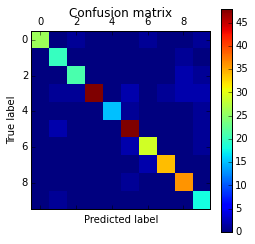

In [ ]:
visualize_confusion_matrix(y_test, y_pred)

## CaffeNet на реальных данных

### Caffe

In [68]:
import sys
caffe_root = '/home/misha/caffe/'
sys.path.insert(0, caffe_root + 'python')

import caffe

### Реальные данные

Все метаданные о фотографиях содержатся файле формата CSV.

In [69]:
import pandas as pd

df = pd.read_csv('datasets/utkin/src/radardump_2016-05-12.csv', header=None)
df.columns = ['cepId', 'plate', 'filepath', 'timestamp', 'brandId', 'generationId', 'modelId']

print(len(df), 'rows')
print(df.head())

159354 rows
   cepId      plate                                           filepath  \
0     61  а079аа150  /media/camPhotos/thumbs/2016-04-30/19c639fd-1f...   
1     72  в432ан777  /media/camPhotos/thumbs/2016-04-30/087e1cd0-43...   
2     73  в828кт177  /media/camPhotos/thumbs/2016-04-30/60495ef6-2c...   
3     91  е389ум199  /media/camPhotos/thumbs/2016-04-30/e800e563-e2...   
4     93  т026мк197  /media/camPhotos/thumbs/2016-04-30/ecdcf8ad-69...   

                timestamp  brandId  generationId  modelId  
0  2016-04-30 00:03:11+03      181          4487     2285  
1  2016-04-30 00:03:24+03      145          3562     1866  
2  2016-04-30 00:03:25+03       90          1968     1077  
3  2016-04-30 00:04:00+03       74          1539      878  
4  2016-04-30 00:04:01+03       10           151       92  


Поправим пути до картинок

In [70]:
from os.path import basename

df['filepath'] = df['filepath'].apply(
    lambda filepath: 'datasets/utkin/src' + filepath[23:]
)
df['filename'] = df['filepath'].apply(basename)

df[['filepath', 'filename']].head()

,filepath,filename
0,datasets/utkin/src/2016-04-30/19c639fd-1fcd-c8...,19c639fd-1fcd-c80a-b90b-bbc2ec4450df.jpg
1,datasets/utkin/src/2016-04-30/087e1cd0-43b6-e4...,087e1cd0-43b6-e421-1ece-cf4782fb22e0.jpg
2,datasets/utkin/src/2016-04-30/60495ef6-2c31-7d...,60495ef6-2c31-7d2e-69ec-2dd8dff4ff74.jpg
3,datasets/utkin/src/2016-04-30/e800e563-e25d-f1...,e800e563-e25d-f111-7994-f7eaa3fe2f58.jpg
4,datasets/utkin/src/2016-04-30/ecdcf8ad-697f-52...,ecdcf8ad-697f-52fc-ad4e-e258817d0ffb.jpg


Оставим только реально существующие картинки

In [71]:
from os.path import exists

df = df.loc[df.filepath.apply(exists)]
print(len(df), 'rows')

137100 rows


Фотографии с камер, сделанные в ночное время, нам не очень-то подходят. Скорее всего придется тренировать на них отедьный классификатор, а пока мы просто их уберем и оставим только фотографии, сделанные в период с 07:00:00 до 19:00:00.

In [72]:
from dateutil.parser import parse

df['time'] = df['timestamp'].apply(lambda t: parse(t).time())

In [73]:
from datetime import time

df = df.loc[(df['time'] > time(7)) & (df['time'] < time(19))]
print(len(df), 'rows')

94658 rows


Данных было и так мало, а стало ещё меньше. Кроме того, наверняка модели в разной степени представлены в выборке. Нужно что-то с этим сделать. Оставим только те модели, для которых в выборке есть хотя бы 100 примеров.

In [74]:
df = df.groupby('generationId').filter(lambda x: len(x) >= 100)
print(len(df), 'rows')
print(len(df['generationId'].unique()), 'generationId')

74586 rows
252 generationId


Перекодируем микросегменты и сохраним табличку в csv-файл.

In [16]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['generationId'])

pd.DataFrame(encoder.classes_).to_csv('generationId.csv', header=False)

Уберем лишние столбцы и перемешаем данные. 75% данных отдадим на тренировку, остальные 25% - на валидацию.

In [230]:
from sklearn.cross_validation import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.filepath, df.generationId, test_size=0.25,
                                                  random_state=42, stratify=df.generationId)

train = pd.concat((X_train, y_train), axis=1)
val = pd.concat((X_val, y_val), axis=1)
train.head()

,filepath,microsegmentId
6289,datasets/utkin/src/2016-05-06/d153e757-6af8-06...,34
68814,datasets/utkin/src/2016-05-09/09739957-affb-6a...,170
65749,datasets/utkin/src/2016-05-09/546a7b8c-7561-17...,90
52813,datasets/utkin/src/2016-05-08/d04eef8e-fc52-19...,73
52178,datasets/utkin/src/2016-05-08/999f9473-65ad-27...,10


Другой подход. Возьмем из каждого микросегмента по 20 примеров на валидацию. Остальное оставим для тренировки.

In [17]:
df = df.iloc[np.random.permutation(len(df))]
class_conunter = [0 for _ in range(len(df.label.unique()))]
train_index, val_index = [], []
for i, label in enumerate(df.label):
    if class_conunter[label] < 20:
        class_conunter[label] += 1
        val_index.append(i)
    else:
        train_index.append(i)
        
train = df.iloc[train_index]
val = df.iloc[val_index]
train.head()

,cepId,plate,filepath,timestamp,brandId,generationId,modelId,filename,time,label
87330,272153,а851нс197,datasets/utkin/src/2016-05-10/ae19c03c-31ad-db...,2016-05-10 08:26:03+03,77,1754,969,ae19c03c-31ad-db39-d628-317f397def54.jpg,08:26:03,69
43503,137481,а285ув197,datasets/utkin/src/2016-05-08/1403aa22-6c1d-91...,2016-05-08 08:27:40+03,77,1754,969,1403aa22-6c1d-9144-20f6-95ab1a8b92e7.jpg,08:27:40,69
93533,292582,н954вр77,datasets/utkin/src/2016-05-10/6486e7e5-5e0d-37...,2016-05-10 11:47:16+03,77,1754,969,6486e7e5-5e0d-3762-b1fc-71840fafb66d.jpg,11:47:16,69
36834,114325,в725рн197,datasets/utkin/src/2016-05-07/ef6ae1c0-c25d-30...,2016-05-07 18:40:22+03,77,1754,969,ef6ae1c0-c25d-3011-82c7-a8bbc6545e83.jpg,18:40:22,69
28378,89356,в553нв197,datasets/utkin/src/2016-05-07/f5ec521c-33b0-6c...,2016-05-07 13:36:48+03,77,1754,969,f5ec521c-33b0-6c37-97da-f9713e5404b8.jpg,13:36:48,69


Приведем данные к формату, которые можно скармить caffe. имя\_файла-метка для train и val должны быть сохранены в файлах train.txt и val.txt соответственно, без заголовка и индексов. Разделитель - пробел.

In [172]:
train['filename'] = train['filepath'].apply(basename)
val['filename'] = val['filepath'].apply(basename)

train[['filename', 'label']].to_csv('datasets/utkin/data/train.txt', sep=' ', header=False, index=False)
val[['filename', 'label']].to_csv('datasets/utkin/data/val.txt', sep=' ', header=False, index=False)

In [152]:
import os
from shutil import copyfile

for i, filepath, generationId in val[['filepath', 'generationId']].itertuples():
    if not os.path.exists('generations/{}'.format(generationId)):
        os.makedirs('generations/{}'.format(generationId))
    copyfile(filepath, 'generations/{}/{}'.format(generationId, basename(filepath)))

Раскидаем фотографии для train и val по соответсвтующим каталогам.

In [173]:
!rm datasets/utkin/data/train/*
!rm datasets/utkin/data/val/*

for img_path in train.filepath:
    img = io.imread(img_path, as_grey=True)
    copyfile(img_path, 'datasets/utkin/data/train/' + basename(img_path))
    
for img_path in val.filepath:
    img = io.imread(img_path, as_grey=True)
    copyfile(img_path, 'datasets/utkin/data/val/' + basename(img_path))

rm: невозможно удалить 'datasets/utkin/data/train/*': Нет такого файла или каталога


Теперь приведем фотографии к формату LMDB и посчинаем от них mean. К счастью, для этого существует пара bash-скриптов, слегка поправленных мною.

In [174]:
!rm -rf datasets/utkin/data/lmdb/*

!scripts/create_net.sh utkin
!scripts/make_net_mean.sh utkin

Creating train lmdb...
I0514 04:53:32.551002 30390 convert_imageset.cpp:83] Shuffling data
I0514 04:53:33.672060 30390 convert_imageset.cpp:86] A total of 69546 images.
I0514 04:53:33.701880 30390 db_lmdb.cpp:38] Opened lmdb datasets/utkin/data/lmdb/utkin_train_lmdb
I0514 04:53:48.591761 30390 convert_imageset.cpp:144] Processed 1000 files.
I0514 04:54:01.048454 30390 convert_imageset.cpp:144] Processed 2000 files.
I0514 04:54:13.680109 30390 convert_imageset.cpp:144] Processed 3000 files.
I0514 04:54:26.919991 30390 convert_imageset.cpp:144] Processed 4000 files.
I0514 04:54:38.351824 30390 convert_imageset.cpp:144] Processed 5000 files.
I0514 04:54:49.883618 30390 convert_imageset.cpp:144] Processed 6000 files.
I0514 04:55:01.323796 30390 convert_imageset.cpp:144] Processed 7000 files.
I0514 04:55:13.155535 30390 convert_imageset.cpp:144] Processed 8000 files.
I0514 04:55:26.103847 30390 convert_imageset.cpp:144] Processed 9000 files.
I0514 04:55:39.018815 30390 convert_imageset.cpp:

### CaffeNet

Настройки сети и солвера я здесь не привожу, но можно и нужно покапаться в них: train_val.prototxt, deploy.prototxt, solver.prototxt.

Вроде бы можно натренировать сеть, используя только интерфейс питона. Но я даже пытаться не буду. И не зря же мы на прошлых шагах приводили данные к формату, которые может воспринимать специальная утилита. Теперь можем натренировать сеть самым тривиальным образом.

In [8]:
!$CAFFE_ROOT/build/tools/caffe train --solver=models/bvlc_reference_caffenet_utkin/solver.prototxt

I0514 06:51:46.320976  2918 caffe.cpp:185] Using GPUs 0
I0514 06:51:46.516719  2918 caffe.cpp:190] GPU 0: GeForce GTX 960
I0514 06:51:47.308770  2918 solver.cpp:48] Initializing solver from parameters: 
test_iter: 1000
test_interval: 500
base_lr: 0.01
display: 20
max_iter: 11000
lr_policy: "step"
gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
stepsize: 100000
snapshot: 10000
snapshot_prefix: "models/bvlc_reference_caffenet_utkin/caffenet_utkin_train"
solver_mode: GPU
device_id: 0
net: "models/bvlc_reference_caffenet_utkin/train_val.prototxt"
I0514 06:51:47.323848  2918 solver.cpp:91] Creating training net from net file: models/bvlc_reference_caffenet_utkin/train_val.prototxt
I0514 06:51:47.325294  2918 net.cpp:313] The NetState phase (0) differed from the phase (1) specified by a rule in layer data
I0514 06:51:47.325372  2918 net.cpp:313] The NetState phase (0) differed from the phase (1) specified by a rule in layer accuracy
I0514 06:51:47.325855  2918 net.cpp:49] Initializing net from

Можно прервать обучение сети, а потом продолжить с желаемого снапшота. Снапшоты снимаются периодически (период задан в параметрах солвера) и при остановке.

Ну и вообще, если сеть внезапно перестала обучаться, то имеет смысл остановить процесс, поменять параметры солвера (base_lr?), а затем продолжить.

In [ ]:
!$CAFFE_ROOT/build/tools/caffe train \
    --solver=models/bvlc_reference_caffenet_utkin/solver.prototxt \
    --snapshot=models/bvlc_reference_caffenet_utkin/caffenet_utkin_train_iter_XXX.solverstate

Такс-такс-такс. 35% за 1к итераций? Посмотрим на сеть в деле.

In [29]:
import time

model_def = 'models/bvlc_reference_caffenet_utkin/deploy.prototxt'
pretrained_model = 'models/bvlc_reference_caffenet_utkin/caffenet_utkin_train_iter_10000.caffemodel'

image_dims = (256, 256)

# load the mean image (as distributed with Caffe) for subtraction
blob = caffe.proto.caffe_pb2.BlobProto()
with open('datasets/utkin/data/utkin_mean.binaryproto', 'rb') as f:
    data = f.read()
blob.ParseFromString(data)
mu = np.array(caffe.io.blobproto_to_array(blob))
mu = mu[0]
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values

channel_swap = (2,1,0)

caffe.set_device(0)
caffe.set_mode_gpu()

# Make classifier.
classifier = caffe.Classifier(model_def, pretrained_model,
                              image_dims=image_dims, mean=mu,
                              raw_scale=255,
                              channel_swap=channel_swap)

val = pd.read_csv('datasets/utkin/data/val.txt', sep=' ', header=None)
val.columns = [['filename', 'label']]
inputs = [caffe.io.load_image('datasets/utkin/data/val/{}'.format(im_f)) for im_f in val.filename]

print('Classifying {} inputs'.format(len(inputs)))

start = time.time()
predictions = classifier.predict(inputs, False)
print('Done in {0:.2f} s'.format(time.time() - start))

print('Saving results into {}'.format('val_results'))
np.save('val_results', predictions)

Classifying 5040 inputs
Done in 136.42 s
Saving results into val_results


Визуализируем матрицу ошибок

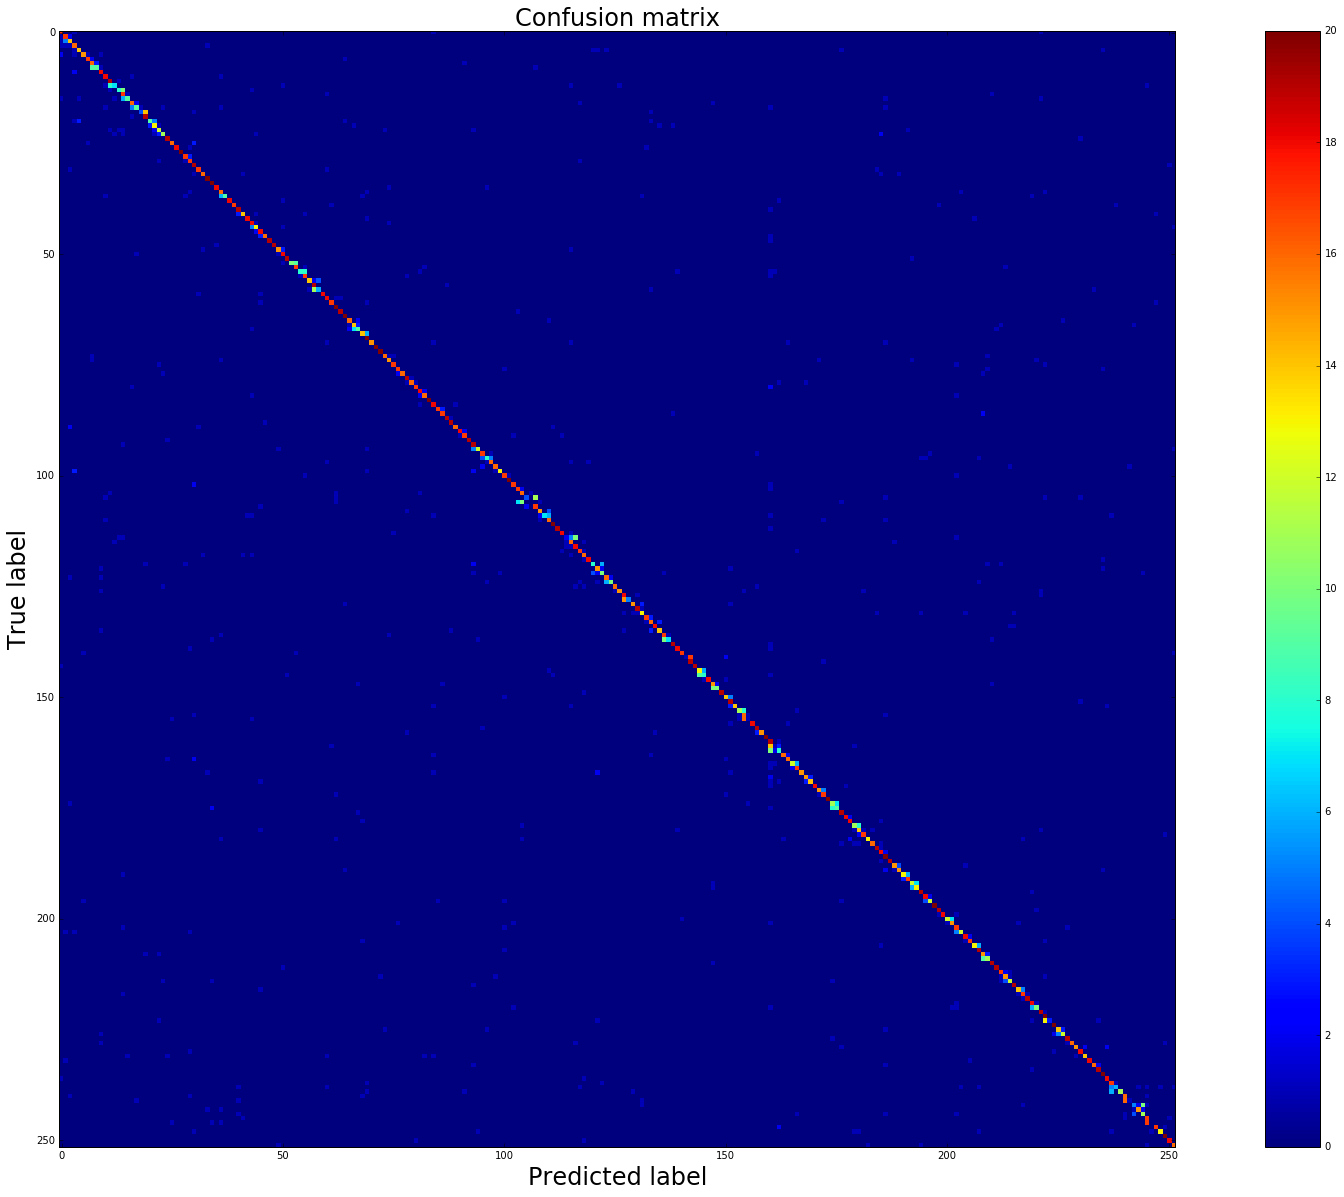

In [52]:
visualize_confusion_matrix(val.label, predictions.argmax(axis=1))

In [103]:
results = pd.read_csv('generationId.csv', header=None)
results.columns = ['generationId', 'accuracy']
results['generationId'] = results['accuracy']
results['accuracy'] = np.diag(cm) / 20
results['# photo'] = list(df.groupby('generationId').size())
results.to_csv('results.csv', index=False)

## И снова RF + HOG

RF давал отличные результаты на искусственных данных. Проверим, как он работает на новых данных. Построим график зависимости точности предсказаний алгоритма от количества классов - будет ограничивать количество, работая только с теми классами, для которых в исходной выборке имеется по крайней мере n примеров. Таким образом, график будет демострировать зависимость точности от n.

In [181]:
def get_preprocessed_metadata(metadata_path, time_interval, min_num_examples_per_class):  
    df = pd.read_csv(metadata_path, header=None)
    df.columns = ['cepId', 'plate', 'filepath', 'timestamp', 'brandId', 'generationId', 'modelId']
    
    df['filepath'] = df['filepath'].apply(
        lambda filepath: 'datasets/utkin/src' + filepath[23:]
    )
    df['filename'] = df['filepath'].apply(basename)
    
    df = df.loc[df.filepath.apply(exists)]
    
    df['time'] = df['timestamp'].apply(lambda t: parse(t).time())    
    df = df.loc[(df['time'] > time_interval[0]) & (df['time'] < time_interval[1])]
    
    df = df.groupby('generationId').filter(lambda x: len(x) >= min_num_examples_per_class)

    encoder = LabelEncoder()
    df['label'] = encoder.fit_transform(df['generationId'])
    
    print(min_num_examples_per_class, 'min num examples per class,',
          len(df), 'rows,',
          len(df['generationId'].unique()), 'classes')
    
    return df

In [182]:
def test_rf_hog(metadata, resize_output_shape=(192, 240),
                hog_pixels_per_cell=(16, 16), hog_cells_per_block=(2, 2)):
    X, y = [], []
    for i, filepath, label in df[['filepath', 'label']].itertuples():
        img = io.imread(filepath, as_grey=True)
        fd = hog(img, pixels_per_cell=hog_pixels_per_cell,
                 cells_per_block=hog_cells_per_block)
        X.append(fd)
        y.append(label)

    clf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
    cv = KFold(len(X), n_folds=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

In [105]:
df = get_preprocessed_metadata(metadata_path='datasets/utkin/src/radardump_2016-05-12.csv',
                               time_interval=(time(7), time(19)),
                               min_num_examples_per_class=100)
scores = test_rf_hog(df)
print('Accuracy:', scores.mean())

NameError: name 'get_preprocessed_metadata' is not defined